# Fine-Tune FLAN-T5 with Reinforcement Learning (PPO) and PEFT to Generate Less-Toxic Summaries

In [2]:
!pip install pandas scikit-learn transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 1.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━

In [2]:
pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/96/4e/970cd3e13ad95aed81102272f0678d8cc48101880b8be5bae8aad22e7f3b/torch-2.2.0-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/b7/f4/6a90020cd2d93349b442bfcb657d0dc91eee65491600b2cb1d388bc98e6b/typing_extensions-4.9.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 60.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Loading the datasets
df_usage = pd.read_csv('/Applications/Gursimran/Projects/duolingo/survey_users_app_usage.csv')
df_survey = pd.read_csv('/Applications/Gursimran/Projects/duolingo/survey_data.csv')

In [3]:
# Joining df_usage and df_survey on the index 'user_id' with suffixes for overlapping columns
df = df_survey.join(df_usage, lsuffix='_survey', rsuffix='_usage')

In [4]:
# Droping unnecessary columns
df = df.drop(['user_id_survey', 'user_id_usage', 'Unnamed: 12'], axis=1)

# Replacing NaN values 
df["daily_goal"] = df["daily_goal"].fillna(value=0)
df["other_resources"] = df["other_resources"].fillna("Not specified")
df["primary_language_motivation_followup"] = df["primary_language_motivation_followup"].fillna("Not specified")

In [34]:
df.head()

,user_id_survey,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,...,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform,Unnamed: 12
0,35c9fc6e72c911e99681dca9049399ef,18-34,"$26,000 - $75,000",JP,Android phone or tablet,"No, I have never paid for Duolingo Plus",Daily,Employed full-time,Yes,Male,...,46.0,True,False,277.0,88.0,741.0,668.0,135.0,137.0,NaN
1,35c9fdde72c911e98630dca9049399ef,18-34,"$26,000 - $75,000",JP,iPhone or iPad,"No, I have never paid for Duolingo Plus",Weekly,Employed full-time,Yes,Male,...,50.0,True,False,62.0,16.0,57.0,57.0,6.0,453.0,NaN
2,35c9feb072c911e9ab4cdca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Yes,Male,...,71.0,False,False,202.0,29.0,315.0,295.0,55.0,1481.0,NaN
3,35c9ff7072c911e9900ddca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"No, but I have previously paid for Duolingo Plus",Daily,Employed full-time,Yes,Female,...,2.0,False,False,2.0,3.0,6.0,5.0,1.0,30.0,NaN
4,35ca002672c911e99effdca9049399ef,35 - 54,"$76,000 - $150,000",JP,Android phone or tablet,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Yes,Male,...,34.0,False,False,216.0,57.0,338.0,297.0,56.0,1144.0,NaN


In [35]:
print(df.describe())

       survey_complete  time_spent_seconds   daily_goal  \
count      6187.000000         6187.000000  2687.000000   
mean          0.925974         3325.057055    25.853740   
std           0.261835        26268.864929    13.707093   
min           0.000000         -297.000000     1.000000   
25%           1.000000          234.000000    20.000000   
50%           1.000000          325.000000    20.000000   
75%           1.000000          470.000000    30.000000   
max           1.000000       584939.000000    50.000000   

       highest_course_progress  highest_crown_count  n_active_days  \
count              6135.000000          5857.000000    6149.000000   
mean                 27.314914           107.126515      49.150106   
std                  20.179992            97.168490      39.212910   
min                 -10.000000             0.000000       1.000000   
25%                  10.000000            30.000000      12.000000   
50%                  26.000000            81.000

In [10]:
print(df.dtypes)

age                                      object
annual_income                            object
country                                  object
duolingo_platform                        object
duolingo_subscriber                      object
duolingo_usage                           object
employment_status                        object
future_contact                           object
gender                                   object
other_resources                          object
primary_language_commitment              object
primary_language_review                  object
primary_language_motivation              object
primary_language_motivation_followup     object
primary_language_proficiency             object
student                                  object
survey_complete                           int64
time_spent_seconds                        int64
duolingo_start_date                      object
daily_goal                              float64
highest_course_progress                 

In [41]:
df.columns

Index(['user_id_survey', 'age', 'annual_income', 'country',
       'duolingo_platform', 'duolingo_subscriber', 'duolingo_usage',
       'employment_status', 'future_contact', 'gender', 'other_resources',
       'primary_language_commitment', 'primary_language_review',
       'primary_language_motivation', 'primary_language_motivation_followup',
       'primary_language_proficiency', 'student', 'survey_complete',
       'time_spent_seconds', 'user_id_usage', 'duolingo_start_date',
       'daily_goal', 'highest_course_progress', 'took_placement_test',
       'purchased_subscription', 'highest_crown_count', 'n_active_days',
       'n_lessons_started', 'n_lessons_completed', 'longest_streak',
       'n_days_on_platform', 'Unnamed: 12'],
      dtype='object')

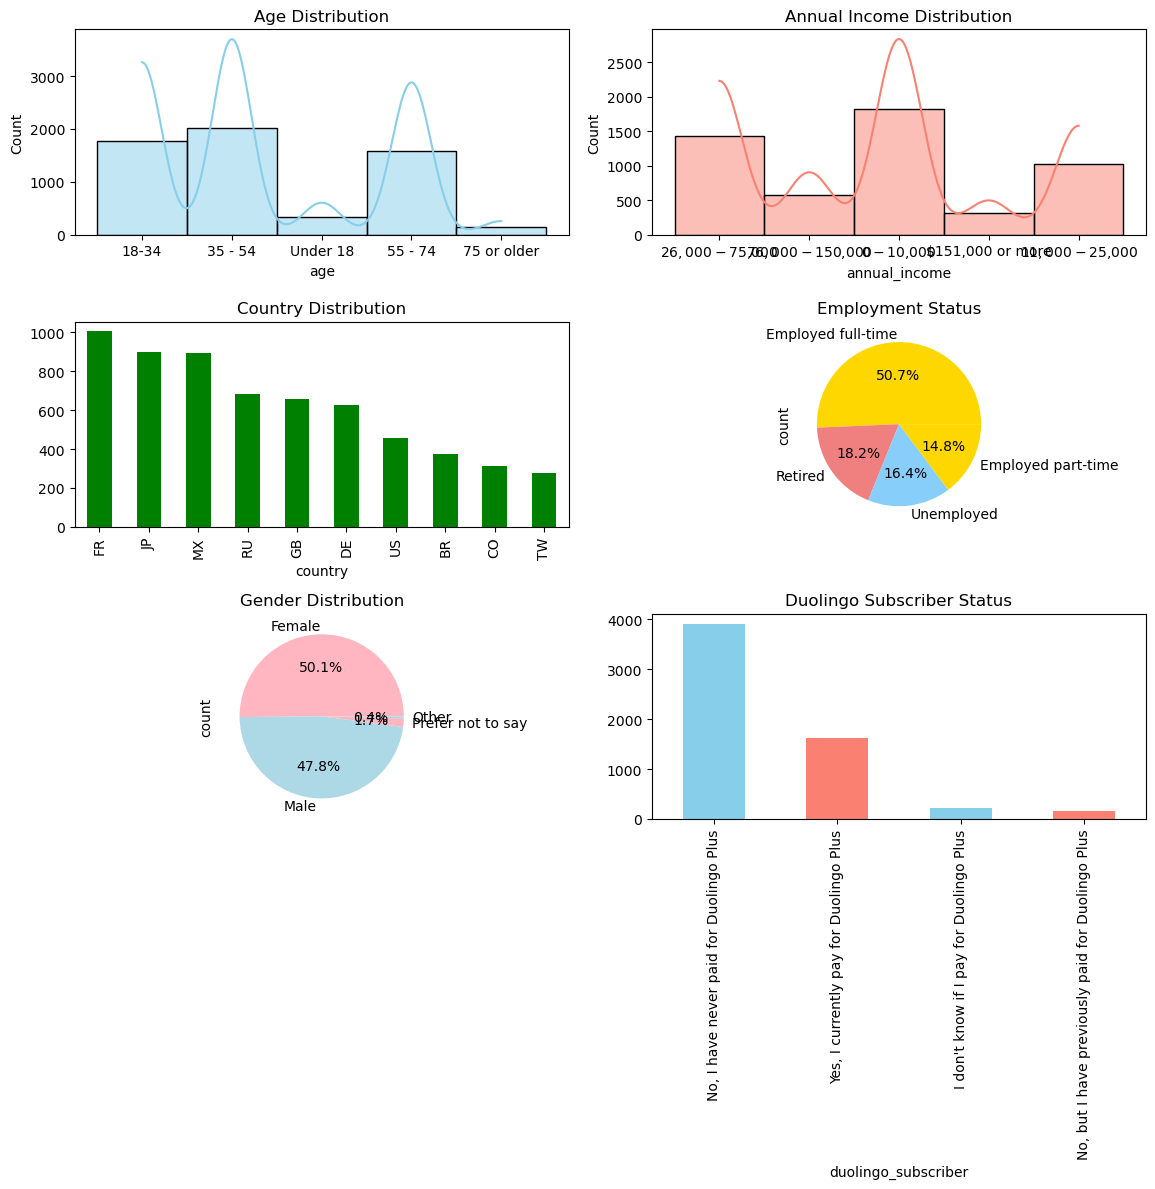

In [5]:
# Creating a figure and axes for subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Age Distribution (Histogram)
sns.histplot(df['age'], kde=True, color='skyblue', ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')

# Annual Income Distribution (Histogram)
sns.histplot(df['annual_income'], kde=True, color='salmon', ax=axs[0, 1])
axs[0, 1].set_title('Annual Income Distribution')

# Country Distribution (Bar Plot)
df['country'].value_counts().plot(kind='bar', ax=axs[1, 0], color='green')
axs[1, 0].set_title('Country Distribution')

# Employment Status (Pie Chart)
df['employment_status'].value_counts().plot(kind='pie', ax=axs[1, 1], autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue'])
axs[1, 1].set_title('Employment Status')

# Gender Distribution (Pie Chart)
df['gender'].value_counts().plot(kind='pie', ax=axs[2, 0], autopct='%1.1f%%', colors=['lightpink', 'lightblue'])
axs[2, 0].set_title('Gender Distribution')

# Duolingo Subscriber Status (Bar Plot)
df['duolingo_subscriber'].value_counts().plot(kind='bar', ax=axs[2, 1], color=['skyblue', 'salmon'])
axs[2, 1].set_title('Duolingo Subscriber Status')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

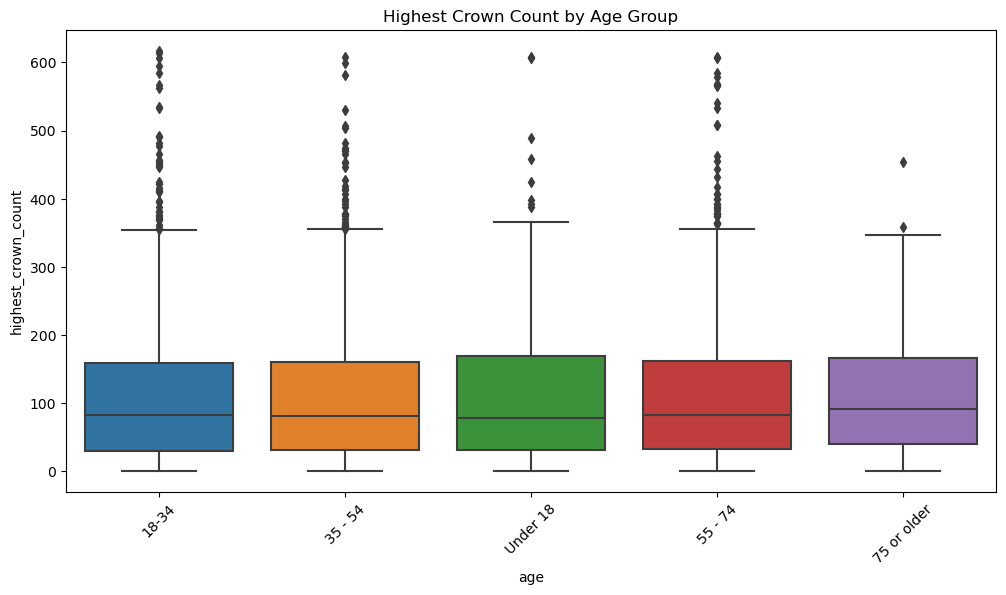

<Figure size 1200x600 with 0 Axes>

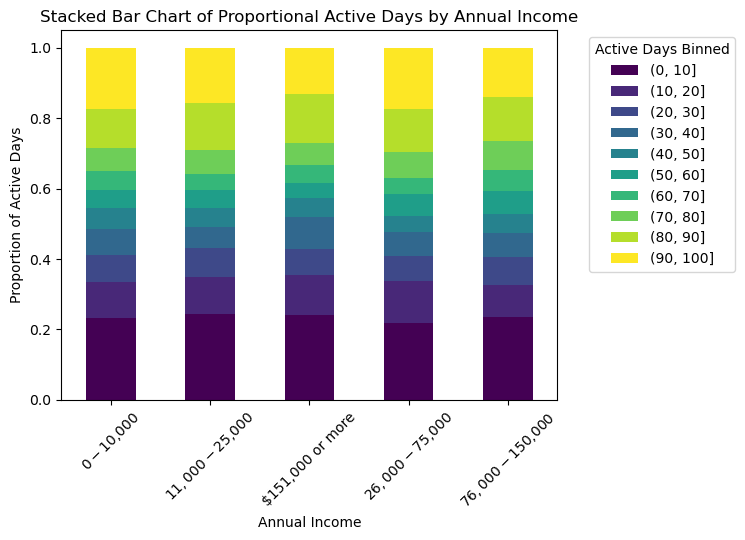

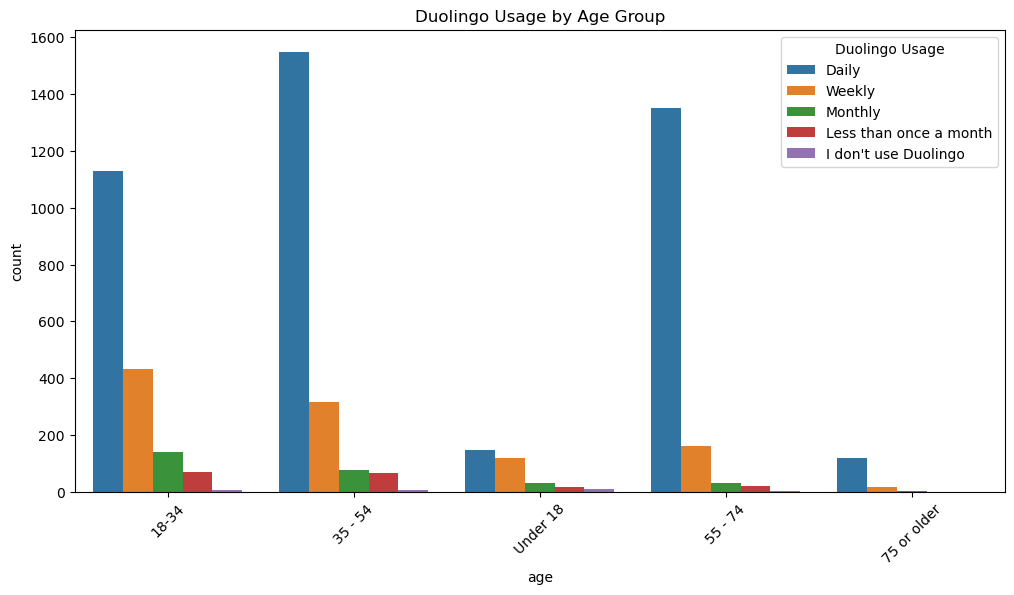

In [10]:
# This block of code is plotting a boxplot to compare the highest crown counts across different age groups.
# It is useful for visualizing the central tendency and dispersion of crown counts within each age category.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='age', y='highest_crown_count')
plt.title('Highest Crown Count by Age Group')
plt.xticks(rotation=45)  # Rotate the x labels to fit them better
plt.show()

# Here, we are grouping the DataFrame by 'annual_income' and then counting the normalized 'n_active_days' to understand the distribution within each income bracket.
# We are creating a stacked bar chart to show the proportion of active days for each income group, which helps in identifying trends in user activity based on income.
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  

# Create a new binned column
df['n_active_days_binned'] = pd.cut(df['n_active_days'], bins=bins)

# Create a proportion of days active based on the new binned column
grouped = df.groupby('annual_income')['n_active_days_binned'].value_counts(normalize=True).unstack().fillna(0)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
grouped.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stacked Bar Chart of Proportional Active Days by Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Proportion of Active Days')
plt.xticks(rotation=45)
plt.legend(title='Active Days Binned', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# This section generates a count plot that shows the frequency of different usage levels of Duolingo across age groups.
# The hue parameter is used to differentiate between usage levels, providing a clear visual distinction of usage patterns among different age demographics.
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='age', hue='duolingo_usage')
plt.title('Duolingo Usage by Age Group')
plt.xticks(rotation=45)
plt.legend(title='Duolingo Usage')
plt.show()


In [7]:
# Encoding categorical variables using OrdinalEncoder
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
df_encoded = df.copy()
df_encoded[categorical_cols] = encoder.fit_transform(df[categorical_cols].astype(str))

# Impute=ing missing values using IterativeImputer (MICE)
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = imputer.fit_transform(df_encoded)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

In [ ]:
# Decoding the categorical variables back to their original values
df_imputed[categorical_cols] = encoder.inverse_transform(df_imputed[categorical_cols])

# Converting numerical columns back to their original data types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    df_imputed[col] = df_imputed[col].astype(df[col].dtype)

# Label encoding for remaining categorical columns (excluding text columns for BERT)
categorical_cols = categorical_cols.drop(['primary_language_motivation_followup', 'other_resources'])
label_encoder = LabelEncoder()
for col in categorical_cols:
    df_imputed[col] = label_encoder.fit_transform(df_imputed[col].astype(str))

In [9]:
# Function to encode text columns using BERT
def encode_texts(texts):
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')
    model.eval()
    
    encoded_features = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        features = outputs.pooler_output if outputs.pooler_output is not None else outputs.last_hidden_state[:, 0]
        encoded_features.append(features.cpu().numpy().ravel())
    
    return np.array(encoded_features)

# Encoding text columns with BERT embeddings
motivation_followup_features = encode_texts(df_imputed['primary_language_motivation_followup'].astype(str))
print("Executing")
other_resources_features = encode_texts(df_imputed['other_resources'].astype(str))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Executing


In [10]:
# Creating feature names for BERT embeddings
num_features = motivation_followup_features.shape[1]
motivation_followup_columns = [f'motivation_followup_emb_{i}' for i in range(num_features)]
other_resources_columns = [f'other_resources_emb_{i}' for i in range(num_features)]

# Creating DataFrames for BERT embeddings
motivation_followup_df = pd.DataFrame(motivation_followup_features, columns=motivation_followup_columns)
other_resources_df = pd.DataFrame(other_resources_features, columns=other_resources_columns)

# Combining the encoded text features with the rest of the dataset
df_combined = pd.concat([df_imputed.drop(['primary_language_motivation_followup', 'other_resources'], axis=1), 
                         motivation_followup_df, other_resources_df], axis=1)

In [11]:
df_combined

,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,primary_language_commitment,...,other_resources_emb_758,other_resources_emb_759,other_resources_emb_760,other_resources_emb_761,other_resources_emb_762,other_resources_emb_763,other_resources_emb_764,other_resources_emb_765,other_resources_emb_766,other_resources_emb_767
0,0.0,3.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,...,0.531540,-0.275700,0.936082,0.901630,-0.359472,0.392083,0.685637,-0.594202,-0.727753,0.839238
1,0.0,3.0,5.0,2.0,1.0,4.0,0.0,1.0,1.0,3.0,...,0.541317,0.086280,0.852444,0.883733,-0.082684,0.467291,0.689826,-0.390723,-0.688723,0.827070
2,0.0,4.0,5.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,...,0.541317,0.086280,0.852444,0.883733,-0.082684,0.467291,0.689826,-0.390723,-0.688723,0.827070
3,0.0,4.0,5.0,2.0,2.0,0.0,0.0,1.0,0.0,4.0,...,0.568429,0.189246,0.776639,0.825311,-0.117580,0.344488,0.720538,-0.354160,-0.617134,0.747757
4,1.0,4.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,4.0,...,0.541317,0.086280,0.852444,0.883733,-0.082684,0.467291,0.689826,-0.390723,-0.688723,0.827070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,1.0,3.0,4.0,2.0,1.0,0.0,0.0,1.0,1.0,4.0,...,0.538833,0.122487,0.873015,0.877195,-0.190558,0.414575,0.687654,-0.487347,-0.671363,0.806099
6183,1.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,...,0.541317,0.086280,0.852444,0.883733,-0.082684,0.467291,0.689826,-0.390723,-0.688723,0.827070
6184,2.0,2.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.560815,0.028261,0.864464,0.896230,-0.341444,0.409857,0.669389,-0.506323,-0.668432,0.847731
6185,2.0,3.0,3.0,0.0,3.0,0.0,2.0,0.0,1.0,4.0,...,0.541317,0.086280,0.852444,0.883733,-0.082684,0.467291,0.689826,-0.390723,-0.688723,0.827070


In [12]:
#df_combined.to_csv("features.csv")

In [13]:
# Standardizing the data before PCA
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_combined)

# Applying PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
df_reduced = pca.fit_transform(df_standardized)

# Converting PCA results into a DataFrame
pca_columns = [f'pca_feature_{i}' for i in range(df_reduced.shape[1])]
df_pca = pd.DataFrame(df_reduced, columns=pca_columns)

In [14]:
#df_pca.to_csv("pca.csv")

In [15]:
df_pca

,pca_feature_0,pca_feature_1,pca_feature_2,pca_feature_3,pca_feature_4,pca_feature_5,pca_feature_6,pca_feature_7,pca_feature_8,pca_feature_9,...,pca_feature_21,pca_feature_22,pca_feature_23,pca_feature_24,pca_feature_25,pca_feature_26,pca_feature_27,pca_feature_28,pca_feature_29,pca_feature_30
0,25.209629,-10.874899,6.985672,11.720474,-10.737289,1.802420,-2.324655,1.004820,-7.066182,-8.803755,...,2.355673,-2.236445,-1.384203,-0.867954,5.302916,-0.875240,0.226420,-2.216669,-1.649190,-0.198171
1,-8.044532,-52.555217,4.235172,2.896200,2.579011,-3.677900,1.462569,-7.912130,-3.982801,6.976895,...,-0.436934,-0.963358,-2.548146,0.195077,-0.755750,-0.486106,1.368499,-0.519212,-0.292719,-0.443687
2,-2.681321,13.058852,-5.067073,-0.104322,-2.697122,-3.441397,-0.294004,-6.146236,0.562056,4.064379,...,-0.037179,-1.005695,-0.349624,-0.173677,-0.119014,1.329811,-0.047861,-0.333618,-0.554723,0.257565
3,-26.949777,-0.308955,18.610917,-21.046564,-1.655998,16.120168,-5.319534,1.468746,5.264542,-5.909827,...,-0.159970,-2.268523,1.483665,0.122206,-0.580647,-2.379580,3.941990,4.046445,0.991744,-1.396369
4,-2.678807,13.063895,-5.068017,-0.106004,-2.682057,-3.443040,-0.296357,-6.143349,0.579292,4.104928,...,-0.070128,-0.991542,-0.346220,-0.044003,-0.226946,1.080554,-0.117927,-0.214695,-0.500061,0.275217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,-3.238140,12.961437,-4.572215,-2.705488,-1.839161,1.976013,-0.325474,-1.452583,0.644091,2.996204,...,0.435599,-0.994460,-0.135322,-0.410629,-1.071375,2.895915,-0.059478,-0.823251,0.406343,-0.655835
6183,-4.687771,-14.483279,-10.654693,-0.013356,5.194606,-4.440305,-12.841761,-5.669262,3.773897,-3.732506,...,0.746805,-0.045179,-2.996875,-0.369706,-0.040859,2.149397,-0.904950,-1.378784,-0.481507,-2.420722
6184,-1.026404,-20.993802,-3.691354,13.566708,2.846554,-7.908816,-10.365288,-0.855963,-4.054524,-4.959993,...,1.956707,-0.496937,0.466356,-1.690423,-1.482711,1.690602,1.142819,-1.101088,-3.726805,2.942103
6185,-2.667518,13.070296,-5.080644,-0.125465,-2.678047,-3.435981,-0.312337,-6.160646,0.558524,4.164948,...,0.135921,-0.763802,-0.291352,-0.374033,0.332703,2.004879,-0.141418,-0.184316,-0.637091,0.257044


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f075cadef80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f075cadef80>
Traceb

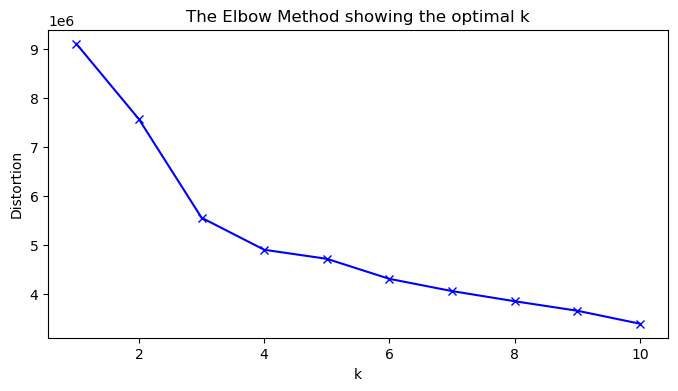

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="threadpoolctl")


# Determining the optimal number of clusters using the elbow method
# Plotting the distortions of K-Means
distortions = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_pca)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f075c84ea70>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f075c84ea70>
Traceb

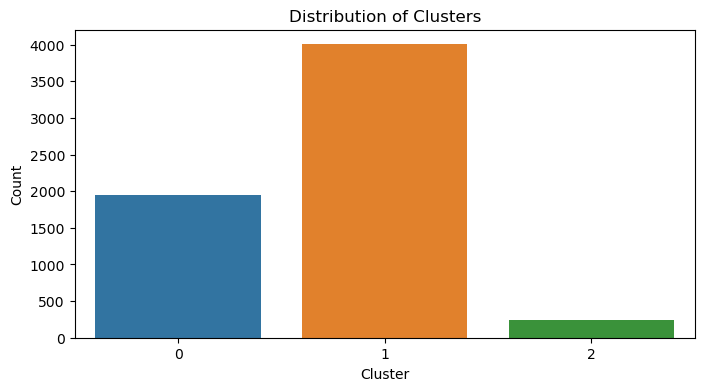

In [21]:
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

# Determined the optimal k (number of clusters) from the elbow plot
# Let's say the optimal k is found to be 3 based on the elbow plot
optimal_k = 3

# Fiting the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_pca)

# Predicting the cluster labels for the observations in df_pca
cluster_labels = kmeans.predict(df_pca)

# Adding the cluster labels as a new column to df_pca
df_pca['cluster'] = cluster_labels

# Visualizing the distribution of data over the clusters
plt.figure(figsize=(8,4))
sns.countplot(x='cluster', data=df_pca)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

         pca_feature_0  pca_feature_1  pca_feature_2  pca_feature_3  \
cluster                                                               
0            -5.342945     -22.842823       4.057273       1.769329   
1            -2.463273      11.456773      -2.253698       0.557191   
2            84.351186      -6.205470       4.752184     -23.619996   

         pca_feature_4  pca_feature_5  pca_feature_6  pca_feature_7  \
cluster                                                               
0             0.253314       0.085175      -0.080700      -0.100487   
1            -0.098009       0.201208       0.030787      -0.033663   
2            -0.415667      -4.046387       0.139715       1.375147   

         pca_feature_8  pca_feature_9  ...  pca_feature_21  pca_feature_22  \
cluster                                ...                                   
0             0.203303      -0.443934  ...       -0.065893       -0.108719   
1            -0.096245       0.150149  ...        0.10

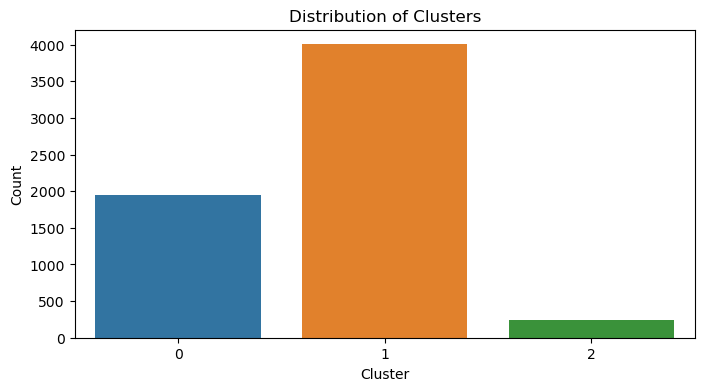

In [30]:
# Assuming that df_combined contains all the original features before PCA
# and that df_pca contains the PCA components

# Now we will create a new DataFrame that includes both the PCA components and the cluster labels
df_pca_with_clusters = df_pca.copy()
df_pca_with_clusters['cluster'] = kmeans.labels_

# Calculating the mean value of each PCA component for each cluster
cluster_means = df_pca_with_clusters.groupby('cluster').mean()

# You can now print these means to get an understanding of each cluster's characteristics
print(cluster_means)

# It can also be helpful to look at the size of each cluster
print(df_pca_with_clusters['cluster'].value_counts())

# Visualizing the distribution of clusters
plt.figure(figsize=(8,4))
sns.countplot(x='cluster', data=df_pca_with_clusters)
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [31]:
#Geting the centroids in the reduced PCA space
centroids_reduced_space = kmeans.cluster_centers_

# Inversing transform the centroids from the reduced PCA space back to the original feature space
# Using the 'pca' object which was already fit to the standardized data
centroids_original_space = pca.inverse_transform(centroids_reduced_space)
print("Cluster centroids (in the original feature space): \n", centroids_original_space)

Cluster centroids (in the original feature space): 
 [[-1.62834540e-01 -6.64616422e-02 -1.14380249e-02 ...  9.62686282e-02
   1.61677476e-01 -1.43196246e-01]
 [ 7.30394973e-02  4.20793780e-02  1.82980800e-03 ...  1.52094265e-01
   9.64864150e-02 -1.15598148e-01]
 [ 9.97390171e-02 -1.63961911e-01  6.20730462e-02 ... -3.31681409e+00
  -2.91862892e+00  3.08785538e+00]]


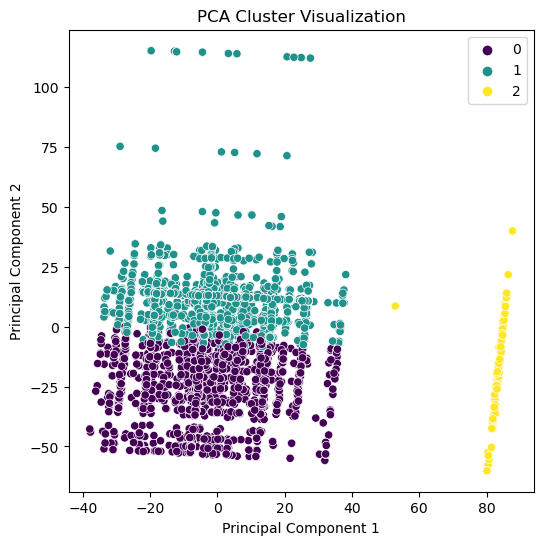

In [27]:
# Visualizing the clusters using the first two principal components
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], hue=df_pca['cluster'], palette='viridis')
plt.title('PCA Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [23]:
# Optionally, you can examine the centroids of the clusters
centroids = kmeans.cluster_centers_
print("Cluster centroids (in the space of Principal Components): \n", centroids)


Cluster centroids (in the space of Principal Components): 
 [[-5.34294463e+00 -2.28428228e+01  4.05727323e+00  1.76932875e+00
   2.53313566e-01  8.51745661e-02 -8.07003502e-02 -1.00487261e-01
   2.03302836e-01 -4.43933672e-01  1.08709698e-01 -2.01140983e-01
  -1.77842991e-01  2.24446207e-01 -3.35741009e-01 -8.88405010e-02
  -2.70427568e-01  1.21895080e-01  9.99012385e-02 -1.72011711e-01
   4.22234734e-01 -6.58929570e-02 -1.08718514e-01  1.11072696e-01
   1.90360618e-01  1.15826433e-01  9.81330945e-02  2.36904088e-02
   1.05759504e-01  7.21121748e-02  7.00652626e-02]
 [-2.46327252e+00  1.14567726e+01 -2.25369784e+00  5.57191145e-01
  -9.80090122e-02  2.01208467e-01  3.07865350e-02 -3.36634452e-02
  -9.62445401e-02  1.50149304e-01 -1.26227464e-01 -2.16876616e-01
   8.81413926e-02 -1.20427148e-01  1.41555721e-01 -8.18480050e-02
   1.33172356e-01 -6.22143829e-02 -4.41793813e-02  8.90539946e-02
  -1.81016713e-01  1.02594612e-01  7.07456443e-03 -4.87979355e-02
  -1.02949060e-01 -2.04242068e-

In [25]:
# Assuming 'pca' is your initial PCA object used to reduce the dimensionality and 'df_reduced' is the reduced data
pca = PCA(n_components=0.95)  # This should be the same PCA object that was initially used
pca.fit(df_standardized)  # df_standardized is your standardized data before reduction

# Fiting KMeans to the reduced data
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_reduced)

# Geting the centroids in the reduced PCA space
centroids_reduced_space = kmeans.cluster_centers_

# Inversing transform the centroids from the reduced PCA space back to the original feature space
centroids_original_space = pca.inverse_transform(centroids_reduced_space)
print("Cluster centroids (in the original feature space): \n", centroids_original_space)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f075c3b75b0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Cluster centroids (in the original feature space): 
 [[-1.62834540e-01 -6.64616422e-02 -1.14380249e-02 ...  9.62686282e-02
   1.61677476e-01 -1.43196246e-01]
 [ 7.30394973e-02  4.20793780e-02  1.82980800e-03 ...  1.52094265e-01
   9.64864150e-02 -1.15598148e-01]
 [ 9.97390171e-02 -1.63961911e-01  6.20730462e-02 ... -3.31681409e+00
  -2.91862892e+00  3.08785538e+00]]


In [28]:
centroids_original_space

array([[-1.62834540e-01, -6.64616422e-02, -1.14380249e-02, ...,
         9.62686282e-02,  1.61677476e-01, -1.43196246e-01],
       [ 7.30394973e-02,  4.20793780e-02,  1.82980800e-03, ...,
         1.52094265e-01,  9.64864150e-02, -1.15598148e-01],
       [ 9.97390171e-02, -1.63961911e-01,  6.20730462e-02, ...,
        -3.31681409e+00, -2.91862892e+00,  3.08785538e+00]])

Cluster 0 feature differences:


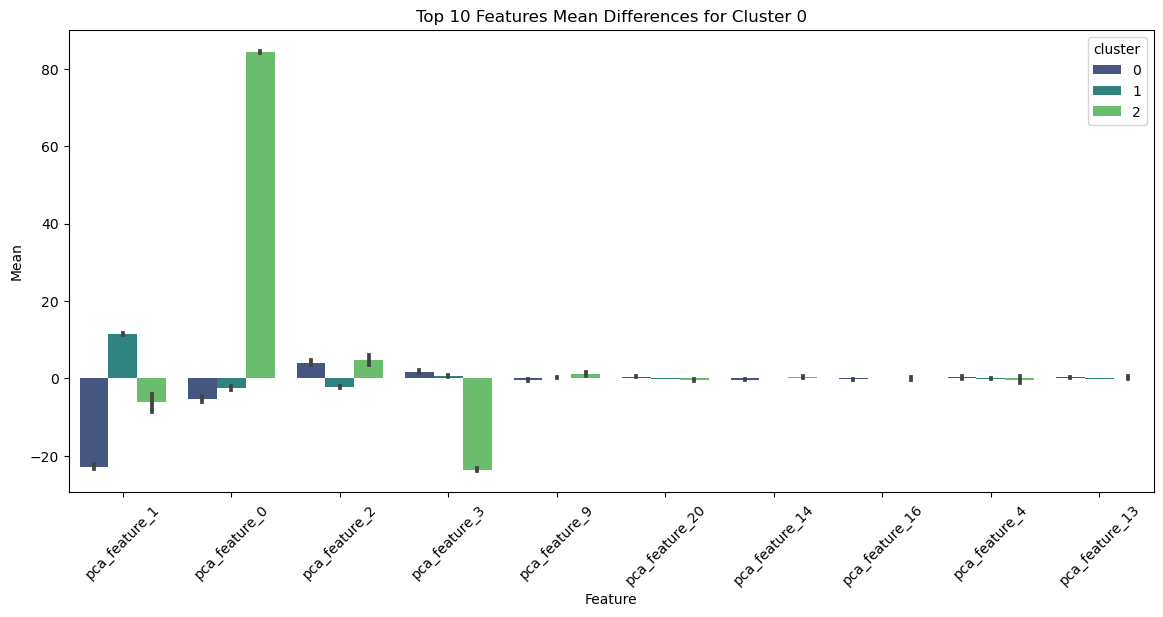

Cluster 1 feature differences:


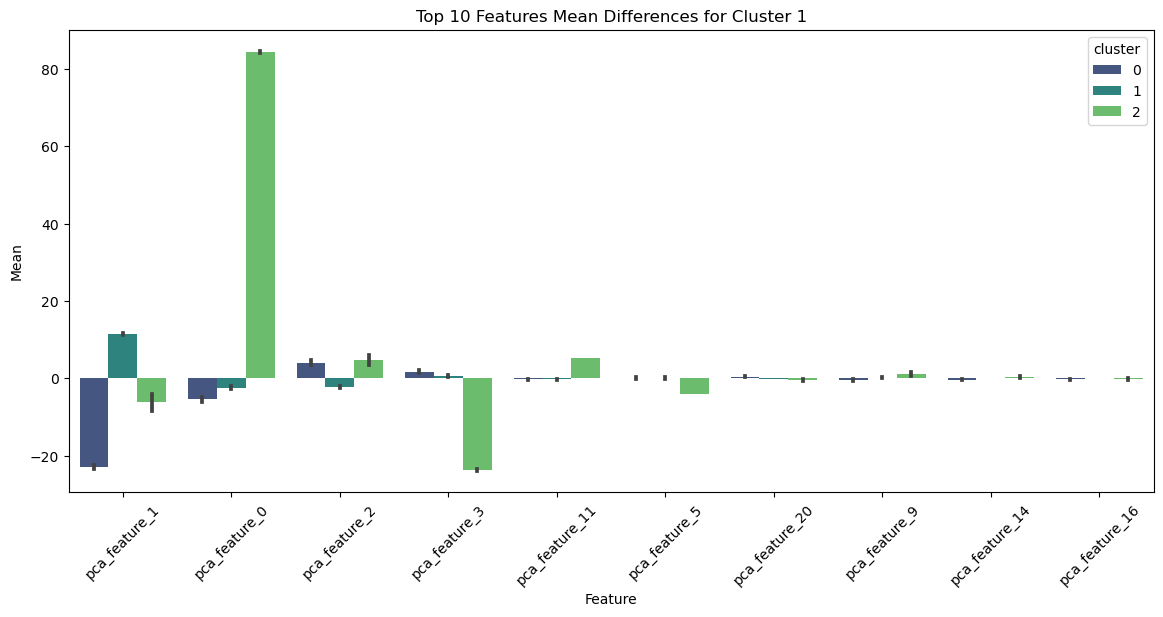

Cluster 2 feature differences:


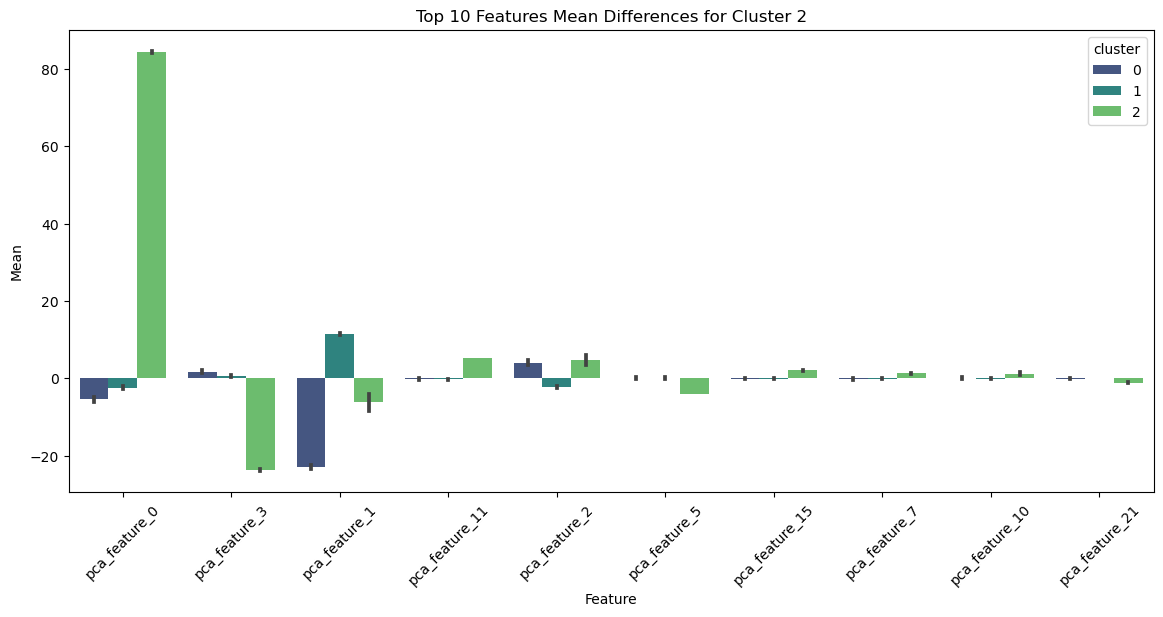

In [32]:

# Assuming optimal_k is the number of clusters be optimal
optimal_k = 3

# Assuming df_pca contains the PCA components and the cluster labels
df_with_clusters = df_pca.copy()

# Calculating the mean value of each feature for each cluster
cluster_means = df_with_clusters.groupby('cluster').mean()

# Calculating the overall mean for each feature
overall_means = df_with_clusters.drop('cluster', axis=1).mean()

# Calculating the difference from the overall mean for each cluster
differences_from_overall = cluster_means.sub(overall_means, axis=1)

# Identifing the top N features with the largest mean difference for each cluster
top_n_features = 10
for cluster_num in range(optimal_k):
    print(f"Cluster {cluster_num} feature differences:")
    sorted_features = differences_from_overall.loc[cluster_num].abs().sort_values(ascending=False)
    top_features = sorted_features.head(top_n_features).index.tolist()
    
    # Creating a DataFrame containing only the top features for this cluster
    top_features_df = df_with_clusters[top_features + ['cluster']]
    
    # Melting the DataFrame to have feature names and values in separate columns
    top_features_melted = top_features_df.melt(id_vars='cluster', value_vars=top_features, var_name='Feature', value_name='Mean')
    
    # Ploting the top features for this cluster
    plt.figure(figsize=(14, 6))
    sns.barplot(data=top_features_melted, x='Feature', y='Mean', hue='cluster', palette='viridis')
    plt.title(f"Top {top_n_features} Features Mean Differences for Cluster {cluster_num}")
    plt.xticks(rotation=45)
    plt.show()


In [33]:

# Assuming df_pca contains the PCA components and the cluster labels
df_with_clusters = df_pca.copy()

# Assuming 'pca' is the PCA object used to reduce the dimensionality
# and 'scaler' is the StandardScaler object used to standardize the data

# Inversing transform the centroids to the scaled space
centroids_scaled = pca.inverse_transform(centroids)

# Inversing transform from scaled space to original space
centroids_original = scaler.inverse_transform(centroids_scaled)

# Creating a DataFrame of the centroids in the original feature space
# Note: Replace 'original_feature_names' with the list of original feature names before PCA and scaling
original_feature_names = ['age', 'annual_income',]  # add all feature names here
df_centroids_original = pd.DataFrame(centroids_original, columns=original_feature_names)

# Visualizing the centroids for interpretation
plt.figure(figsize=(10, 6))
sns.heatmap(df_centroids_original, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Cluster Centroids in Original Feature Space')
plt.show()



ValueError: Shape of passed values is (3, 1563), indices imply (3, 2)

In [ ]:
# For each cluster, print the top features that define the cluster
for i, row in df_centroids_original.iterrows():
    print(f'Cluster {i} top defining features:')
    top_features = row.sort_values(ascending=False).head(5)  # Adjust number of top features you want to look at
    print(top_features.to_string())
    print()

# Visualizing how each cluster differs based on a specific feature
feature_to_visualize = 'age'  # Replace with the feature you want to visualize
sns.boxplot(x='cluster', y=feature_to_visualize, data=df_with_clusters)
plt.title(f'Distribution of {feature_to_visualize} across Clusters')
plt.show()

# Make inferences based on the clusters and the original features
# For example:
# If cluster 0 has the highest value for 'age', you might infer it represents older users
# If cluster 1 has the highest value for 'duolingo_usage', it could represent the most active users
# Document these inferences in your report

# Add your interpretations based on the visualizations and the centroids
# For example:
# "Cluster 0, characterized by older age and higher annual income, may represent more mature learners with greater financial resources. This group may be targeted with premium features."
# Repeat for other clusters

# Remember to consider the number of users in each cluster
# A very small cluster may not be as significant for broad marketing strategies
cluster_sizes = df_with_clusters['cluster'].value_counts()
print(cluster_sizes)


cluster
1    4004
0    1943
2     240
Name: count, dtype: int64


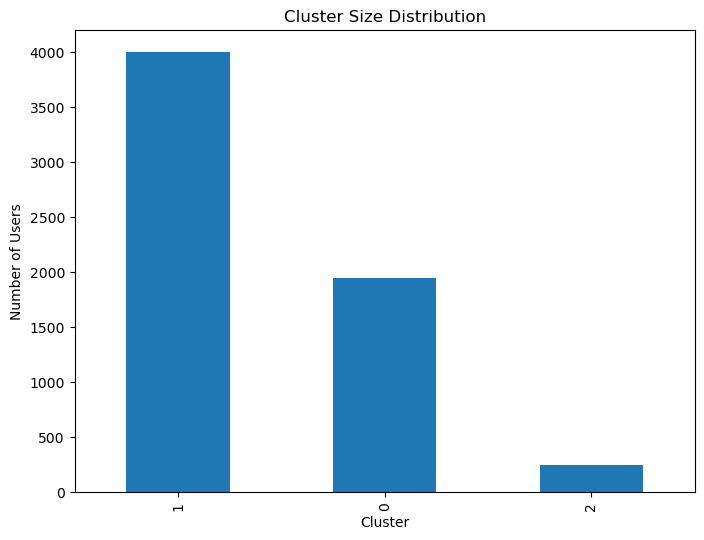

In [34]:
# Assuming df_pca already has the 'cluster' column added from the KMeans labels
cluster_sizes = df_pca['cluster'].value_counts()
print(cluster_sizes)

# Visualizing the distribution of clusters
plt.figure(figsize=(8, 6))
cluster_sizes.plot(kind='bar')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()

Top PCA components with the largest mean difference between clusters:
pca_feature_0     39.224131
pca_feature_1     11.547075
pca_feature_3     11.014781
pca_feature_2      2.959301
pca_feature_11     2.424728
dtype: float64


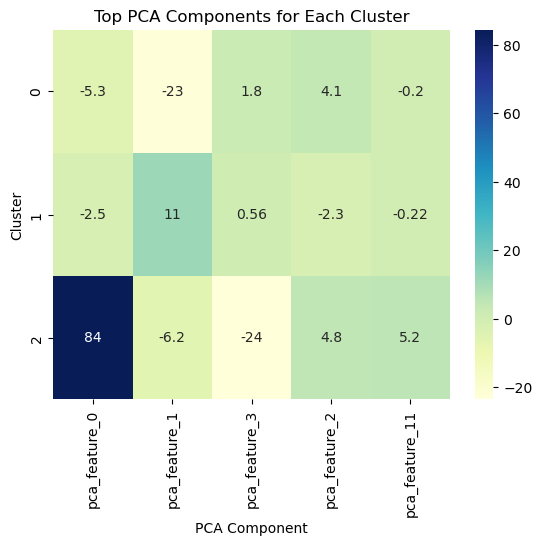

In [35]:
# Calculating the absolute differences from the overall mean for each PCA component
differences_from_overall = cluster_means.sub(cluster_means.mean()).abs()

# Finding top components that have the largest mean difference for each cluster
top_components = differences_from_overall.mean(axis=0).sort_values(ascending=False).head(5)
print("Top PCA components with the largest mean difference between clusters:")
print(top_components)

# Visualizing the top PCA components for each cluster
sns.heatmap(cluster_means[top_components.index], annot=True, cmap="YlGnBu")
plt.title('Top PCA Components for Each Cluster')
plt.xlabel('PCA Component')
plt.ylabel('Cluster')
plt.show()

In [36]:
# Interpreting the clusters based on the top PCA components
# This is hypothetical and should be refined with actual feature mappings
for cluster_num in cluster_means.index:
    print(f"\nCluster {cluster_num} Insights:")
    if cluster_means.loc[cluster_num, top_components.index[0]] > cluster_means[top_components.index[0]].mean():
        print("- Represents users with higher overall engagement.")
    else:
        print("- Represents users with lower overall engagement.")
    
    if cluster_means.loc[cluster_num, top_components.index[1]] > cluster_means[top_components.index[1]].mean():
        print("- Tends to have different content preferences or learning behavior.")
    
    # Add more interpretations based on the other top components
    # ...



Cluster 0 Insights:
- Represents users with lower overall engagement.

Cluster 1 Insights:
- Represents users with lower overall engagement.
- Tends to have different content preferences or learning behavior.

Cluster 2 Insights:
- Represents users with higher overall engagement.


In [37]:
for cluster_num in cluster_means.index:
    print(f"\nCluster {cluster_num} Insights:")
    
    # Interpretation based on the first principal component
    if cluster_means.loc[cluster_num, 'pca_feature_0'] > cluster_means['pca_feature_0'].mean():
        print("- Likely represents users with higher overall engagement.")
    else:
        print("- Likely represents users with lower overall engagement.")
    
    # Interpretation based on the second principal component
    if cluster_means.loc[cluster_num, 'pca_feature_1'] > cluster_means['pca_feature_1'].mean():
        print("- May have preferences for diverse content or exhibit varied learning behavior.")
    else:
        print("- May prefer a more consistent type of content or have a uniform learning style.")
    
    # Interpretation based on the third principal component
    if cluster_means.loc[cluster_num, 'pca_feature_3'] > cluster_means['pca_feature_3'].mean():
        print("- Could indicate a tendency towards specific features or interaction patterns with the platform.")
    else:
        print("- Might suggest a more standard use of the platform without strong preferences.")
    
    # Interpretation based on the fourth principal component
    if cluster_means.loc[cluster_num, 'pca_feature_2'] > cluster_means['pca_feature_2'].mean():
        print("- Might represent users who are either newer to the platform or have sporadic activity patterns.")
    else:
        print("- Likely indicates users with longer-term or consistent use of the platform.")
    
    # Interpretation based on the fifth principal component
    if cluster_means.loc[cluster_num, 'pca_feature_11'] > cluster_means['pca_feature_11'].mean():
        print("- Could correspond to users with specific goals or motivations for using the service.")
    else:
        print("- May represent users with more general or less-defined goals for using the service.")
    
    print()



Cluster 0 Insights:
- Likely represents users with lower overall engagement.
- May prefer a more consistent type of content or have a uniform learning style.
- Could indicate a tendency towards specific features or interaction patterns with the platform.
- Might represent users who are either newer to the platform or have sporadic activity patterns.
- May represent users with more general or less-defined goals for using the service.


Cluster 1 Insights:
- Likely represents users with lower overall engagement.
- May have preferences for diverse content or exhibit varied learning behavior.
- Could indicate a tendency towards specific features or interaction patterns with the platform.
- Likely indicates users with longer-term or consistent use of the platform.
- May represent users with more general or less-defined goals for using the service.


Cluster 2 Insights:
- Likely represents users with higher overall engagement.
- May prefer a more consistent type of content or have a uniform

In this notebook, you will fine-tune a FLAN-T5 model to generate less toxic content with Meta AI's hate speech reward model. The reward model is a binary classifier that predicts either "not hate" or "hate" for the given text. You will use Proximal Policy Optimization (PPO) to fine-tune and reduce the model's toxicity.

# Table of Contents

- [ 1 - Set up Kernel and Required Dependencies](#1)
- [ 2 - Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator](#2)
  - [ 2.1 - Load Data and FLAN-T5 Model Fine-Tuned with Summarization Instruction](#2.1)
  - [ 2.2 - Prepare Reward Model](#2.2)
  - [ 2.3 - Evaluate Toxicity](#2.3)
- [ 3 - Perform Fine-Tuning to Detoxify the Summaries](#3)
  - [ 3.1 - Initialize `PPOTrainer`](#3.1)
  - [ 3.2 - Fine-Tune the Model](#3.2)
  - [ 3.3 - Evaluate the Model Quantitatively](#3.3)
  - [ 3.4 - Evaluate the Model Qualitatively](#3.4)

<a name='1'></a>
## 1 - Set up Kernel and Required Dependencies

First, check that the correct kernel is chosen.

<img src="images/kernel_set_up.png" width="300"/>

You can click on that (top right of the screen) to see and check the details of the image, kernel, and instance type.

<img src="images/w3_kernel_and_instance_type.png" width="600"/>



In [ ]:
import os

instance_type_expected = 'ml-m5-2xlarge'
instance_type_current = os.environ.get('HOSTNAME')

print(f'Expected instance type: instance-datascience-{instance_type_expected}')
print(f'Currently chosen instance type: {instance_type_current}')

assert instance_type_expected in instance_type_current, f'ERROR. You selected the {instance_type_current} instance type. Please select {instance_type_expected} instead as shown on the screenshot above'
print("Instance type has been chosen correctly.")

Now install the required packages to use PyTorch and Hugging Face transformers and datasets.



In [ ]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    peft==0.3.0 --quiet

# Installing the Reinforcement Learning library directly from github.
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd    

Import the necessary components. Some of them are new for this week, they will be discussed later in the notebook. 

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_dataset
from peft import PeftModel, PeftConfig, LoraConfig, TaskType

# trl: Transformer Reinforcement Learning library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead
from trl import create_reference_model
from trl.core import LengthSampler

import torch
import evaluate

import numpy as np
import pandas as pd

# tqdm library makes the loops show a smart progress meter.
from tqdm import tqdm
tqdm.pandas()

<a name='2'></a>
## 2 - Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator

<a name='2.1'></a>
### 2.1 - Load Data and FLAN-T5 Model Fine-Tuned with Summarization Instruction

You will keep working with the same Hugging Face dataset [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) and the pre-trained model [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5). 

In [ ]:
model_name="google/flan-t5-base"
huggingface_dataset_name = "knkarthick/dialogsum"

dataset_original = load_dataset(huggingface_dataset_name)

dataset_original

The next step will be to preprocess the dataset. You will take only a part of it, then filter the dialogues of a particular length (just to make those examples long enough and, at the same time, easy to read). Then wrap each dialogue with the instruction and tokenize the prompts. Save the token ids in the field `input_ids` and decoded version of the prompts in the field `query`.

You could do that all step by step in the cell below, but it is a good habit to organize that all in a function `build_dataset`:

In [ ]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length, 
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.
        
    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """
    
    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")
    
    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")
    
    def tokenize(sample):
        
        # Wrap each dialogue with the instruction.
        prompt = f"""
Summarize the following conversation.

{sample["dialogue"]}

Summary:
"""
        sample["input_ids"] = tokenizer.encode(prompt)
        
        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue.
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")
    
    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200, 
                        input_max_text_length=1000)

print(dataset)

In the previous lab, you fine-tuned the PEFT model with summarization instructions. The training in the notebook was done on a subset of data. Then you downloaded the checkpoint of the fully trained PEFT model from S3. 

Let's load the same model checkpoint here:

In [ ]:
!aws s3 cp --recursive s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/ ./peft-dialogue-summary-checkpoint-from-s3/ 

List the model item and check its size (it's less than 15 Mb):

In [ ]:
!ls -alh ./peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin

Prepare a function to pull out the number of model parameters (it is the same as in the previous lab):

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

Add the adapter to the original FLAN-T5 model. In the previous lab you were adding the fully trained adapter only for inferences, so there was no need to pass LoRA configurations doing that. Now you need to pass them to the constructed PEFT model, also putting `is_trainable=True`.

In [ ]:
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, 
                                              torch_dtype=torch.bfloat16)

peft_model = PeftModel.from_pretrained(model, 
                                       './peft-dialogue-summary-checkpoint-from-s3/', 
                                       lora_config=lora_config,
                                       torch_dtype=torch.bfloat16, 
                                       device_map="auto",                                       
                                       is_trainable=True)

print(f'PEFT model parameters to be updated:\n{print_number_of_trainable_model_parameters(peft_model)}\n')


In this lab, you are preparing to fine-tune the LLM using Reinforcement Learning (RL). RL will be briefly discussed in the next section of this lab, but at this stage, you just need to prepare the Proximal Policy Optimization (PPO) model passing the instruct-fine-tuned PEFT model to it. PPO will be used to optimize the RL policy against the reward model.

In [ ]:
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,                                                               
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

print(f'PPO model parameters to be updated (ValueHead + 769 params):\n{print_number_of_trainable_model_parameters(ppo_model)}\n')
print(ppo_model.v_head)

During PPO, only a few parameters will be updated. Specifically, the parameters of the `ValueHead`. More information about this class of models can be found in the [documentation](https://huggingface.co/docs/trl/main/en/models#trl.create_reference_model). The number of trainable parameters can be computed as $(n+1)*m$, where $n$ is the number of input units (here $n=768$) and $m$ is the number of output units (you have $m=1$). The $+1$ term in the equation takes into account the bias term.

Now create a frozen copy of the PPO which will not be fine-tuned - a reference model. The reference model will represent the LLM before detoxification. None of the parameters of the reference model will be updated during PPO training. This is on purpose.

In [ ]:
ref_model = create_reference_model(ppo_model)

print(f'Reference model parameters to be updated:\n{print_number_of_trainable_model_parameters(ref_model)}\n')

Everything is set. It is time to prepare the reward model!

<a name='2.2'></a>
### 2.2 - Prepare Reward Model

**Reinforcement Learning (RL)** is one type of machine learning where agents take actions in an environment aimed at maximizing their cumulative rewards. The agent's behavior is defined by the **policy**. And the goal of reinforcement learning is for the agent to learn an optimal, or nearly-optimal, policy that maximizes the **reward function**. 

In the [previous section](#2.1) the original policy is based on the instruct PEFT model - this is the LLM before detoxification. Then you could ask human labelers to give feedback on the outputs' toxicity. However, it can be expensive to use them for the entire fine-tuning process. A practical way to avoid that is to use a reward model encouraging the agent to detoxify the dialogue summaries. The intuitive approach would be to do some form of sentiment analysis across two classes (`nothate` and `hate`) and give a higher reward if there is higher a chance of getting class `nothate` as an output. 

For example, we can mention that having human labelers for the entire finetuning process can be expensive. A practical way to avoid that is to use a reward model.

use feedback generated by a model

You will use [Meta AI's RoBERTa-based hate speech model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) for the reward model. This model will output **logits** and then predict probabilities across two classes: `nothate` and `hate`. The logits of the output `nothate` will be taken as a positive reward. Then, the model will be fine-tuned with PPO using those reward values.

Create the instance of the required model class for the RoBERTa model. You also need to load a tokenizer to test the model. Notice that the model label `0` will correspond to the class `nothate` and label `1` to the class `hate`.

In [ ]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto")
print(toxicity_model.config.id2label)

Take some non-toxic text, tokenize it, and pass it to the model. Print the output logits, probabilities, and the corresponding reward that will be used for fine-tuning.

In [ ]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."

toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

Let's show a toxic comment.  This will have a low reward because it is more toxic.

In [ ]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist() 
print(f'reward (low): {nothate_reward}')

Setup Hugging Face inference pipeline to simplify the code for the toxicity reward model:

In [ ]:
device = 0 if torch.cuda.is_available() else "cpu"

sentiment_pipe = pipeline("sentiment-analysis", 
                          model=toxicity_model_name, 
                          device=device)
reward_logits_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # Set to "none" to retrieve raw logits.
    "batch_size": 16
}

reward_probabilities_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "softmax", # Set to "softmax" to apply softmax and retrieve probabilities.
    "batch_size": 16
}

print("Reward model output:")
print("For non-toxic text")
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))
print("For toxic text")
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

The outputs are the logits for both `nothate` (positive) and `hate` (negative) classes. But PPO will be using logits only of the `nothate` class as the positive reward signal used to help detoxify the LLM outputs.

In [ ]:
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))

In [ ]:
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

<a name='2.3'></a>
### 2.3 - Evaluate Toxicity

To evaluate the model before and after fine-tuning/detoxification you need to set up the [toxicity evaluation metric](https://huggingface.co/spaces/evaluate-measurement/toxicity). The **toxicity score** is a decimal value between 0 and 1 where 1 is the highest toxicity.

In [ ]:
toxicity_evaluator = evaluate.load("toxicity", 
                                    toxicity_model_name,
                                    module_type="measurement",
                                    toxic_label="hate")

Try to calculate toxicity for the same sentences as in section [2.2](#2.2). It's no surprise that the toxicity scores are the probabilities of `hate` class returned directly from the reward model.

In [ ]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])

print("Toxicity score for non-toxic text:")
print(toxicity_score["toxicity"])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])

print("\nToxicity score for toxic text:")
print(toxicity_score["toxicity"])

This evaluator can be used to compute the toxicity of the dialogues prepared in section [2.1](#2.1). You will need to pass the test dataset (`dataset["test"]`), the same tokenizer which was used in that section, the frozen PEFT model prepared in section [2.2](#2.2), and the toxicity evaluator. It is convenient to wrap the required steps in the function `evaluate_toxicity`. 

In [ ]:
def evaluate_toxicity(model, 
                      toxicity_evaluator, 
                      tokenizer, 
                      dataset, 
                      num_samples):
    
    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model (trl model): Model to be evaluated.
    - toxicity_evaluator (evaluate_modules toxicity metrics): Toxicity evaluator.
    - tokenizer (transformers tokenizer): Tokenizer to be used.
    - dataset (dataset): Input dataset for the evaluation.
    - num_samples (int): Maximum number of samples for the evaluation.
        
    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean (numpy.float64): Mean of the samples toxicity.
    - std (numpy.float64): Standard deviation of the samples toxicity.
    """

    max_new_tokens=100

    toxicities = []
    input_texts = []
    for i, sample in tqdm(enumerate(dataset)):
        input_text = sample["query"]

        if i > num_samples:
            break
            
        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids
        
        generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

        response_token_ids = model.generate(input_ids=input_ids,
                                            generation_config=generation_config)
        
        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)
        
        toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

        toxicities.extend(toxicity_score["toxicity"])

    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)
        
    return mean, std

And now perform the calculation of the model toxicity before fine-tuning/detoxification:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

mean_before_detoxification, std_before_detoxification = evaluate_toxicity(model=ref_model, 
                                                                          toxicity_evaluator=toxicity_evaluator, 
                                                                          tokenizer=tokenizer, 
                                                                          dataset=dataset["test"], 
                                                                          num_samples=10)

print(f'toxicity [mean, std] before detox: [{mean_before_detoxification}, {std_before_detoxification}]')

<a name='3'></a>
## 3 - Perform Fine-Tuning to Detoxify the Summaries
Optimize a RL policy against the reward model using Proximal Policy Optimization (PPO).

<a name='3.1'></a>
### 3.1 - Initialize `PPOTrainer`
 
For the `PPOTrainer` initialization, you will need a collator. Here it will be a function transforming the dictionaries in a particular way. You can define and test it:

In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Set up the configuration parameters. Load the `ppo_model` and the tokenizer. You will also load a frozen version of the model `ref_model`. The first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This works as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original LLM.

In [ ]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16

config = PPOConfig(
    model_name=model_name,    
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

ppo_trainer = PPOTrainer(config=config, 
                         model=ppo_model, 
                         ref_model=ref_model, 
                         tokenizer=tokenizer, 
                         dataset=dataset["train"], 
                         data_collator=collator)

<a name='3.2'></a>
### 3.2 - Fine-Tune the Model

The fine-tuning loop consists of the following main steps:
1. Get the query responses from the policy LLM (PEFT model).
2. Get sentiments for query/responses from hate speech RoBERTa model.
3. Optimize policy with PPO using the (query, response, reward) triplet.

The operation is running if you see the following metrics appearing:
* `objective/kl`: minimize kl divergence,
* `ppo/returns/mean`: maximize mean returns,
* `ppo/policy/advantages_mean`: maximize advantages.

In [ ]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break   

    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()        
            
        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)
        
        summary_tensors.append(summary.squeeze()[-max_new_tokens:])
        
    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]    
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]    

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)
    
    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

<a name='3.3'></a>
### 3.3 - Evaluate the Model Quantitatively

Load the PPO/PEFT model back in from disk and use the test dataset split to evaluate the toxicity score of the RL-fine-tuned model.

In [ ]:
mean_after_detoxification, std_after_detoxification = evaluate_toxicity(model=ppo_model, 
                                                                        toxicity_evaluator=toxicity_evaluator, 
                                                                        tokenizer=tokenizer, 
                                                                        dataset=dataset["test"], 
                                                                        num_samples=10)
print(f'toxicity [mean, std] after detox: [{mean_after_detoxification}, {std_after_detoxification}]')

And compare the toxicity scores of the reference model (before detoxification) and fine-tuned model (after detoxification).

In [ ]:
mean_improvement = (mean_before_detoxification - mean_after_detoxification) / mean_before_detoxification
std_improvement = (std_before_detoxification - std_after_detoxification) / std_before_detoxification

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

<a name='3.4'></a>
### 3.4 - Evaluate the Model Qualitatively

Let's inspect some examples from the test dataset. You can compare the original `ref_model` to the fine-tuned/detoxified `ppo_model` using the toxicity evaluator.


​

In [ ]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    gen_len = output_length_sampler()
    generation_kwargs["max_new_tokens"] = gen_len
    
    summary = ref_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors_ref.append(summary)

    summary = ppo_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device), 
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors.append(summary)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

Store and review the results in a DataFrame

In [ ]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

Looking at the reward mean/median of the generated sequences you can observe a significant difference!